## Sparse Coding of Natural Images & Digits

##### Jay Dhanoa (jdhanoa) and Andy Ham (ahamn)

I'm using python's multiprocessing library throughout this, because A: the data we're working with isn't that big, and B: it doesn't have *nearly* the amount of overhead that Spark does.

### Part 1: Olshausen-Field Images

Loading/quickly inspecting the images:

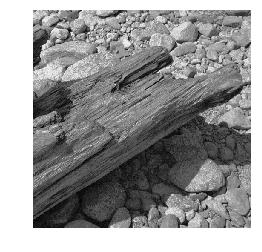

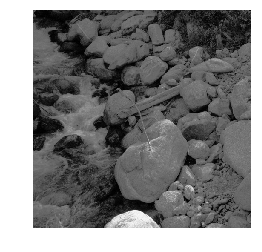

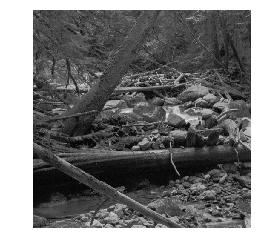

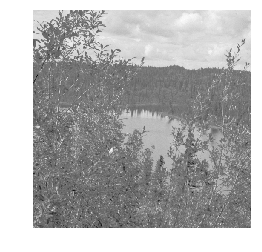

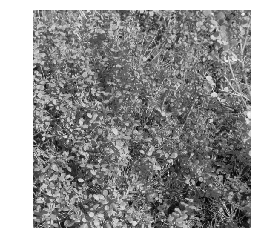

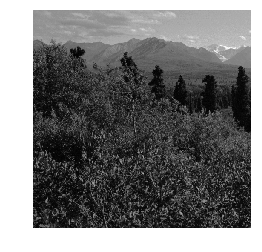

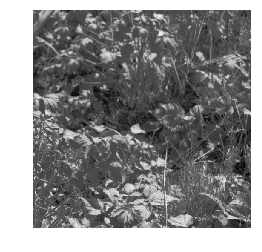

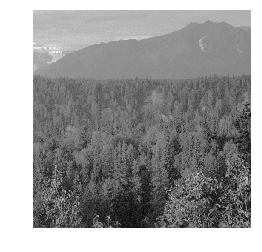

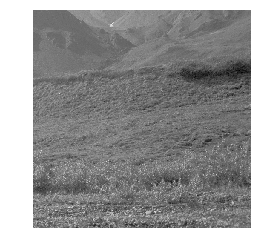

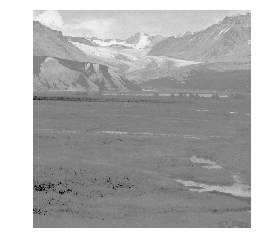

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[28]').appName('sparse').getOrCreate()

import scipy.io
data = scipy.io.loadmat('/project/cmsc25025/sparsecoding/IMAGES_RAW.mat')
images = data['IMAGESr']

import matplotlib.pyplot as plt
for x in range(10):
    plt.imshow(images[:,:,x],cmap='gray')
    plt.axis('off')
    plt.show()

All appears to be well.

From the lab writeup: We have $N$ vectors $y^{(i)}$, corresponding to the set of input images. The goal is to build a dictionary $X \in \mathbb{R}^{n \times d}$, where each column corresponds to an image representation of a local feature. For now, we're just going to start out with a $d=200$, in accordance with the example given in lecture slides (week-3-sgd-sparse-coding(2).pdf, slide 45).

So we know that $X$ is gong to be of the dimensions $256 \times d$, and $y^{(i)}$ (our input component) will be $2500 \times 1$. Each of our codewords is going to be $256$ units long, and we're going to have $d$ codewords. In accordance with the notion of overcompleteness (namely, that we have *many* more codewords than regular words), I'm going to put down $20,000$ ($8n$) codewords.

#### Summary of selected constants
* $N=100$ 
    * 10 samples/image, 100 samples/batch
* $n=16$ 
    * For a $16 \times 16$ image, giving us a square with $\frac{1}{1024}$th the area of the original image)
* $d=200$ 
    * Per Lafferty's comments in class regarding sparse coding over these images, 200 codewords is sufficient. The original Olshausen-Field paper used 192 code words.

Per the lab writeup, our approach should be as follows:
* Sample $N$ sub-images from our lineup of images
* For each input $y^{(i)}$, we carry out a sparse regression (or OMP) onto the dictionary $X$, finding the coefficients $\beta^{(i)}$.
* The dictionary is updated according to:
$$X_j \leftarrow X_j - \eta g_j $$
$$ X_j \leftarrow \frac{X_j}{\|X_j\|} \text{ if } \|X_j\|>1 $$
Where our stochastic gradient is represented as:
$$ g_j = - \sum_{i \in 1,...,\text{batch_size}} \beta_j^{(i)} \left(y^{(i)}-X\beta^{(i)}\right)$$

Where $\beta_j^{(i)}$ is the $j$-th entry of $\beta^{(i)}$, and $\text{batch_size=100}$

Note that for our sparsity constant, $\lambda$, Lafferty suggested in class that a good starting value would be $\sqrt{\frac{c \log{(d)}}{n}}$, for some arbitrary $c$. I wasn't able to find a good value of $c$. Given time constraints, as well as the fact that the iterative nature of gradient calculation leaves us a *little* tight on speed, we're going to use sklearn's OMP.

In [2]:
import math
import random
import numpy

d=200 # number of atoms in code book
img_width = 16 # we're going to be doing 256 unit-long features
n = img_width ** 2
N = 10 # number of samples per image
lam = math.sqrt(math.log(d)/n) # deprecated
X = numpy.random.rand(n,d)

def learning_rate(t):
    """Implemented as a function for the convenience"""
    return 1/math.sqrt(t)

def reshape_patch(patch):
    patch = numpy.reshape(patch,(n,))
    return patch

def map_reshape_patch(samples):
    results = []
    for x in range(10*N):
        results.append(reshape_patch(samples[:,:,x]))
    return results

def sample_random_square_patches(images,num,width):
    patches = numpy.zeros([width,width,10*num])
    for x in range(10):
        image = images[:,:,x]
        for k in range(num):
            i, j = random.sample(range(image.shape[0]-width),2)
            patches[:,:,10*x+k] = image[i:i+width,j:j+width]
    return patches

def sample_flattened_patches(images,num,width):
    samples = sample_random_square_patches(images,num,width)
    samples = map_reshape_patch(samples)
    return samples

# so at this point, samples contains 100 images
# each of which is in a numpy matrix

print("Current value of lambda/sparsity constant: {}".format(lam))
print("Current dimensions of X:")
print(X.shape)

Current value of lambda/sparsity constant: 0.143862963313
Current dimensions of X:
(256, 200)


With our constants, sparsity value, and randomized feature matrix $X$ in hand, we can actually proceed to the algorithm for generation, itself.

**Note**: I deprecated lasso regression sort of last-minute, in favor of OMP, because of the fact that for each image I got very inconsistent results for the sparsity of $\beta^{(i)}$. Sometimes, it would have 0 nonzero elements, other times it would have 20-25. I've experimented a lot with various values of $\lambda$ (which took a fair amount of time), and that didn't really help.

INITIAL CODEBOOK


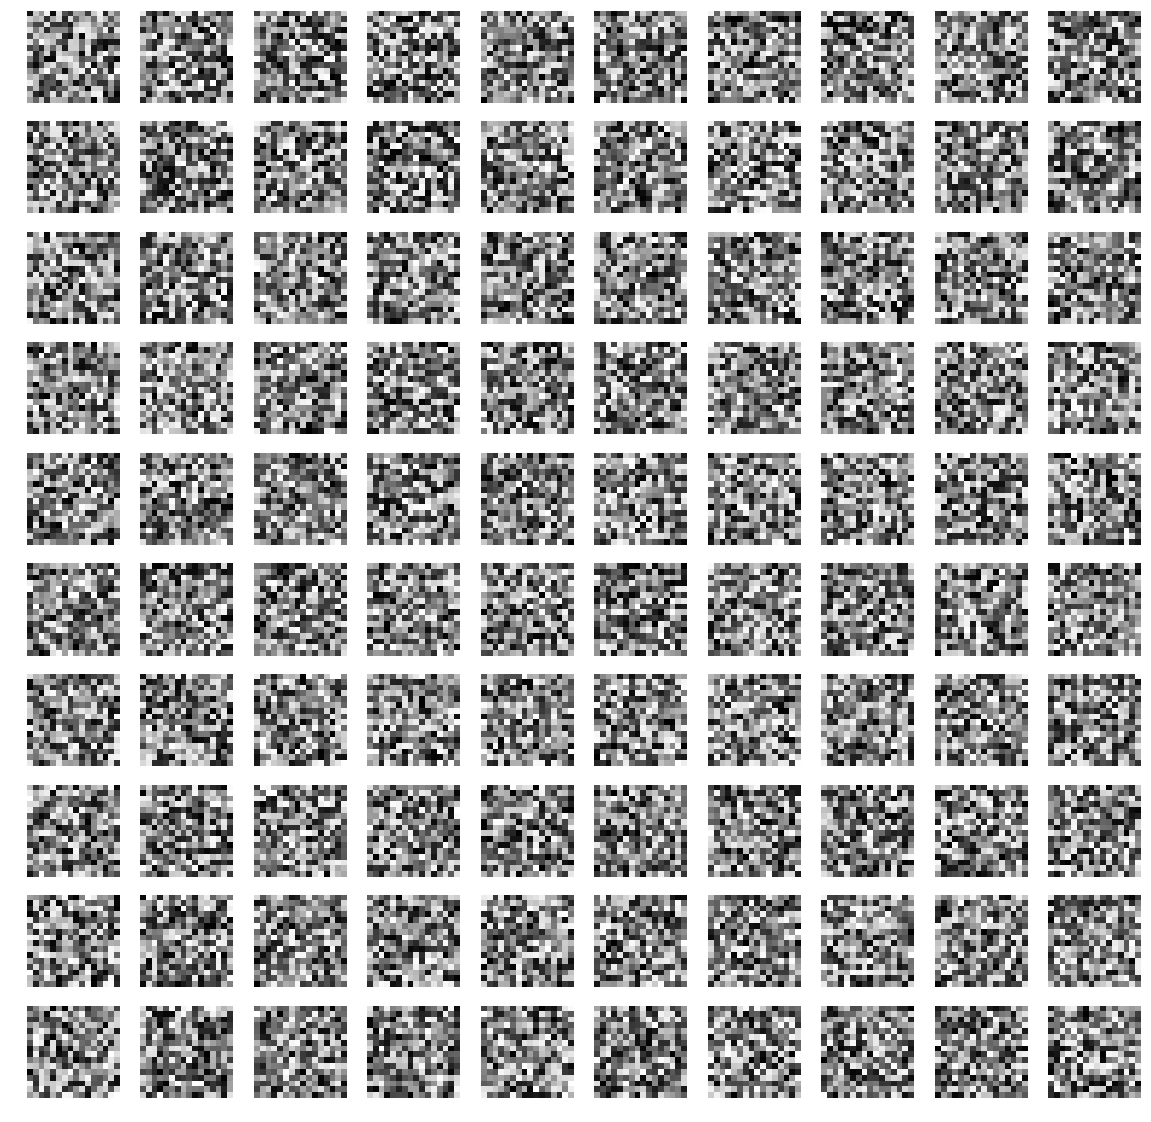

In [3]:
from sklearn import linear_model
import time

"""Riperino these functions"""
# def lasso_regression(y, X=X, lam=lam/5):
#     # with a larger value of lambda, I wound up getting very noisy features
#     clf = linear_model.Lasso(alpha=lam,max_iter=2000)
#     clf.fit(X,y)
#     beta= clf.coef_
#     print(numpy.count_nonzero(beta))
#     return beta

# def myOMP(y_matrix, X, k=10):
#     r = y
#     b_m = numpy.zeros((y.shape[0],X.shape[1]))
#     S = set()
#     B = set(range(X.shape[1]))
#     for i in xrange(k):
#         X = X.T
#         max_val = 0
#         j_max = -1
#         for j in B:
#             calculated = math.abs(np.dot(r.T,X[j]))/np.linalg.norm(X[j])
#             if calculated>max_val:
#                 max_val = calculated
#                 j_max = j
#         B.discard(j_max)
#         b_m[j_max] = r-b_m[j_max]X_[j_max]
#         X = X.T
#     return b_m


"""We're doing OMP instead"""
"""10 non-zero values per beta"""
def OMP(tup, k=10):
    y, X = tup
    clf = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=10)
    clf.fit(X,y)
    beta = clf.coef_
    return beta

def l1norm(x):
    return numpy.linalg.norm(x,ord=1)

def l2norm(x):
    return numpy.linalg.norm(x, ord=2)

def get_g(tup):
    i, y_matrix, X, beta_matrix, j = tup
    return beta_matrix[i][j] * (y_matrix[i]-numpy.dot(X, beta_matrix[i]))

def calculate_gradient(tup):
    j, y_matrix, X, beta_matrix, t = tup
    g_j = 0
    # this for loop is, by far, the slowest part of this approach
    # I should vectorize this
    for i in range(len(y_matrix)):
        g_j += beta_matrix[i][j] * (y_matrix[i]-numpy.dot(X, beta_matrix[i]))
    g_j = learning_rate(t) * -g_j
    return g_j

def calculate_gradient_vector(y_matrix, X, beta_matrix, t, pool):
    g_j_list = [(j, y_matrix, X, beta_matrix, t) for j in range(d)]
    g_j_list = pool.map(calculate_gradient,g_j_list)
    return g_j_list

def iterate(X, i, t_prev=1):
    start = time.time()
    for t in range(t_prev,t_prev+i):
        y_matrix = sample_flattened_patches(images, N, img_width)
        beta_matrix = pool.map(OMP,[(elem, X) for elem in y_matrix])
        grad_list = calculate_gradient_vector(y_matrix, X, beta_matrix, t, pool)
        X = X.T
        for i in range(d):
            X[i]-= grad_list[i]
            if l2norm(X[i]>1):
                X[i] /= l2norm(X[i])
        X = X.T
    end = time.time()
    print("{} s".format(int(end-start)))
    return X, t
        
%matplotlib inline
import matplotlib.pyplot as plt

def display_codebook(X):
    ncols = 10
    nrows = 10
    plt.figure(figsize=(ncols*2,nrows*2))
    for i in xrange(nrows*ncols):
        plt.subplot(nrows,ncols,i+1)
        plt.imshow(X[:,i].reshape((16,16)),cmap='gray')
        plt.axis('off')
    plt.axis('off')
    plt.show()

    
print("INITIAL CODEBOOK")
display_codebook(X)

We usually get ~0.4s seconds per iteration, with current settings.

Inspecting the array after 20 iterations:

8 s


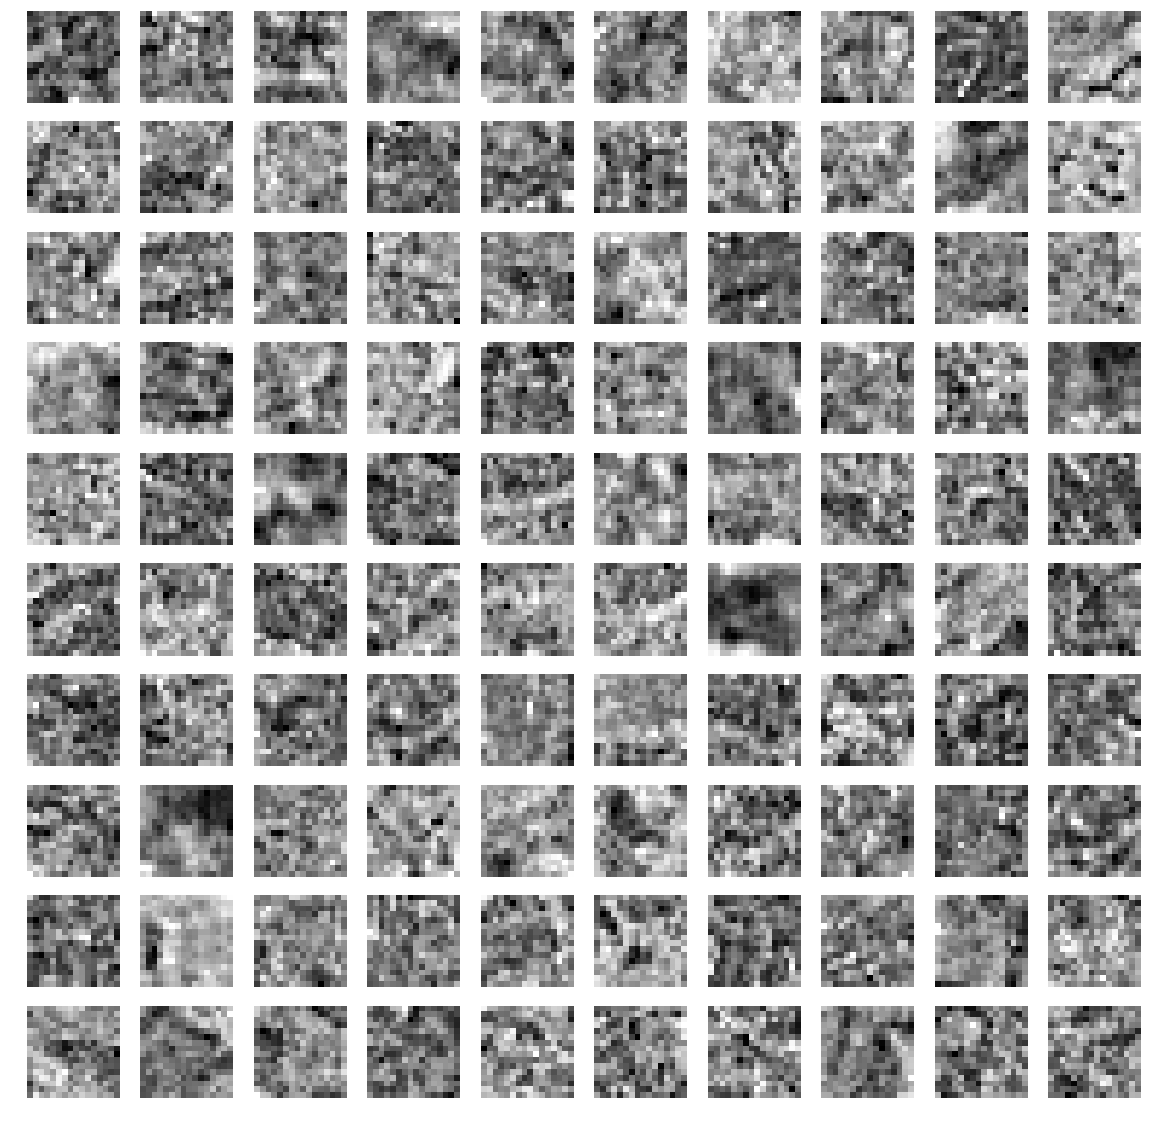

In [4]:
import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())

X, t = iterate(X, 20)
display_codebook(X)

After 100 iterations:

33 s


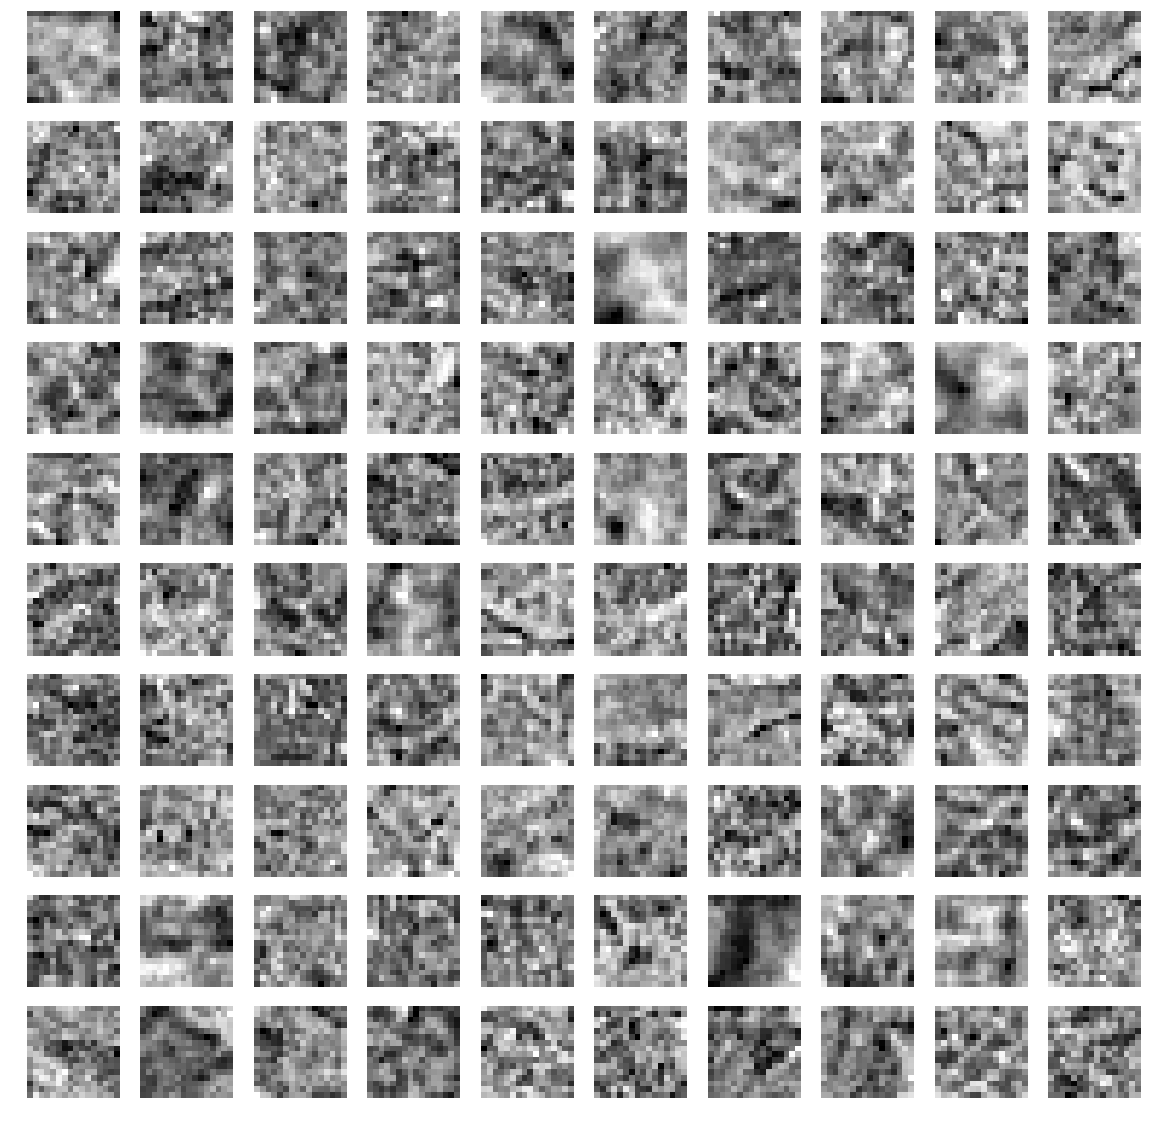

In [5]:
X, t = iterate(X, 80, 20)
display_codebook(X)

168 s


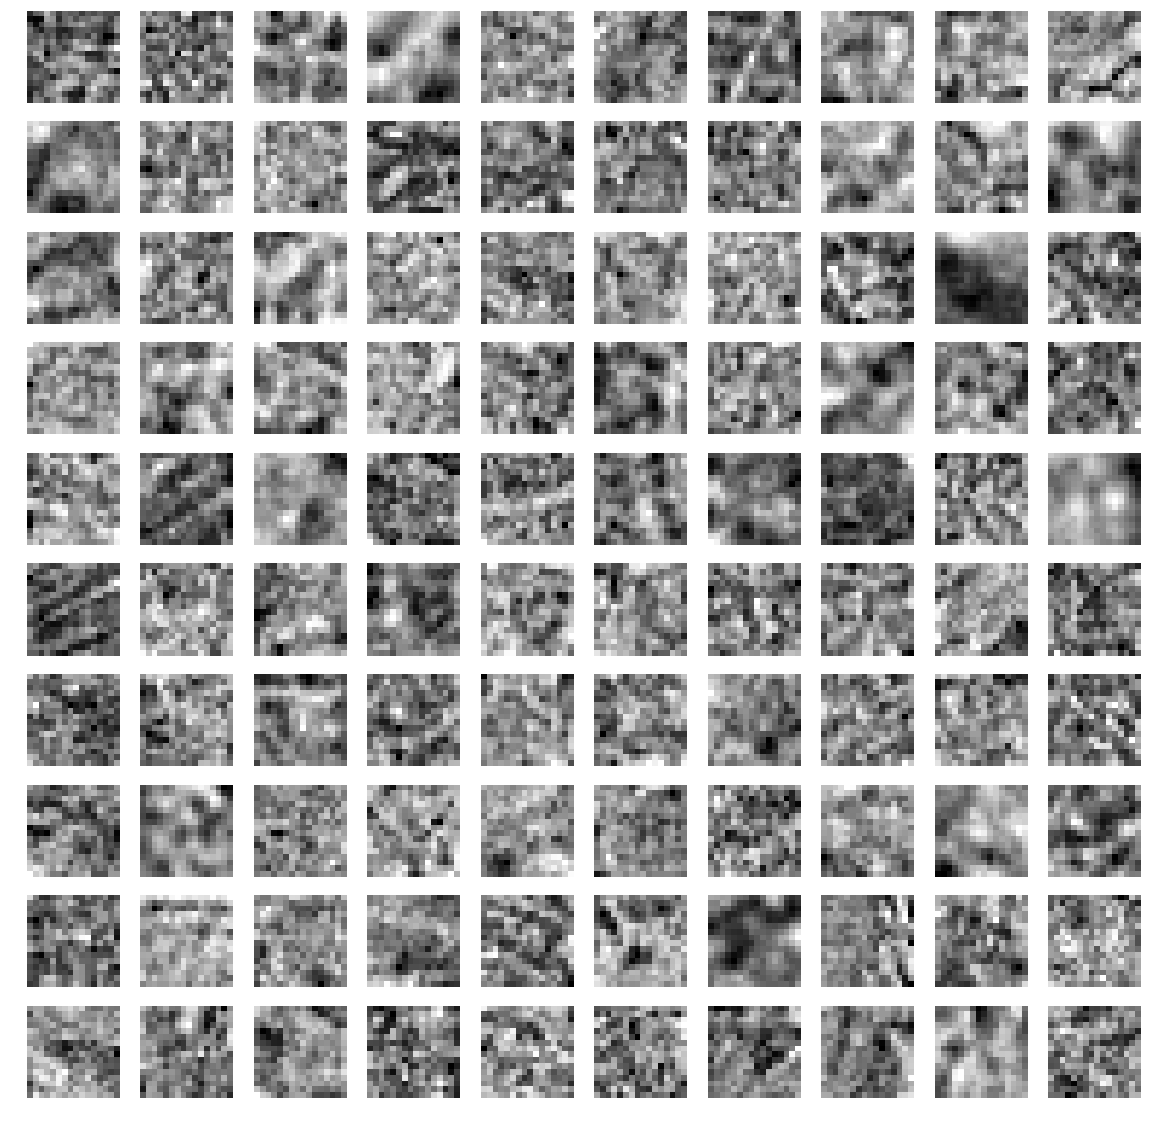

In [6]:
X, t = iterate(X, 400, 100) # 500 iterations
display_codebook(X)

204 s


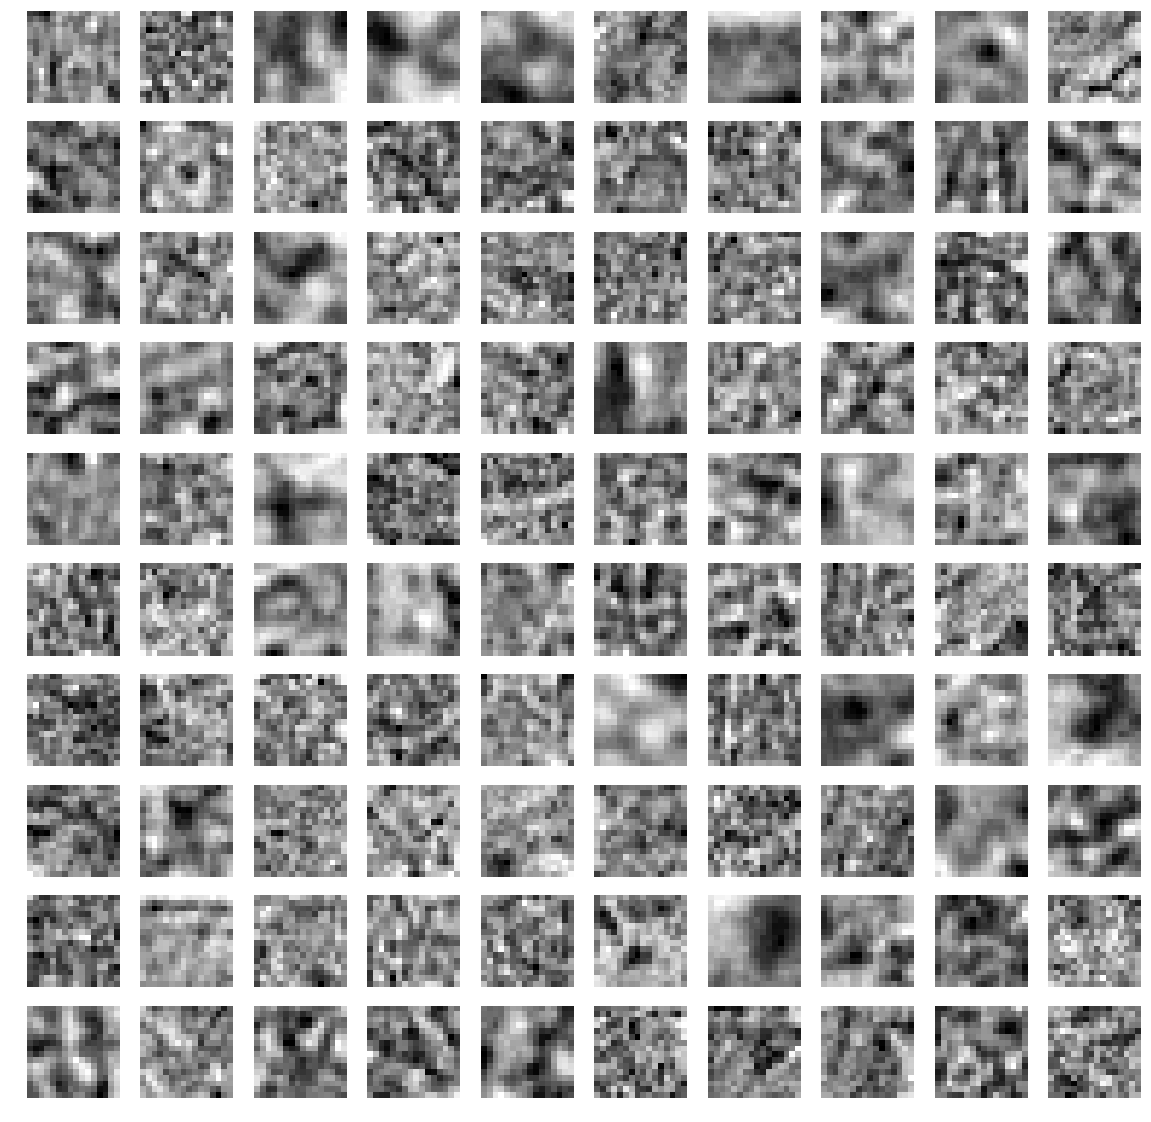

In [7]:
X, t = iterate(X, 500, 500) # currently at 1k iterations
display_codebook(X)

412 s


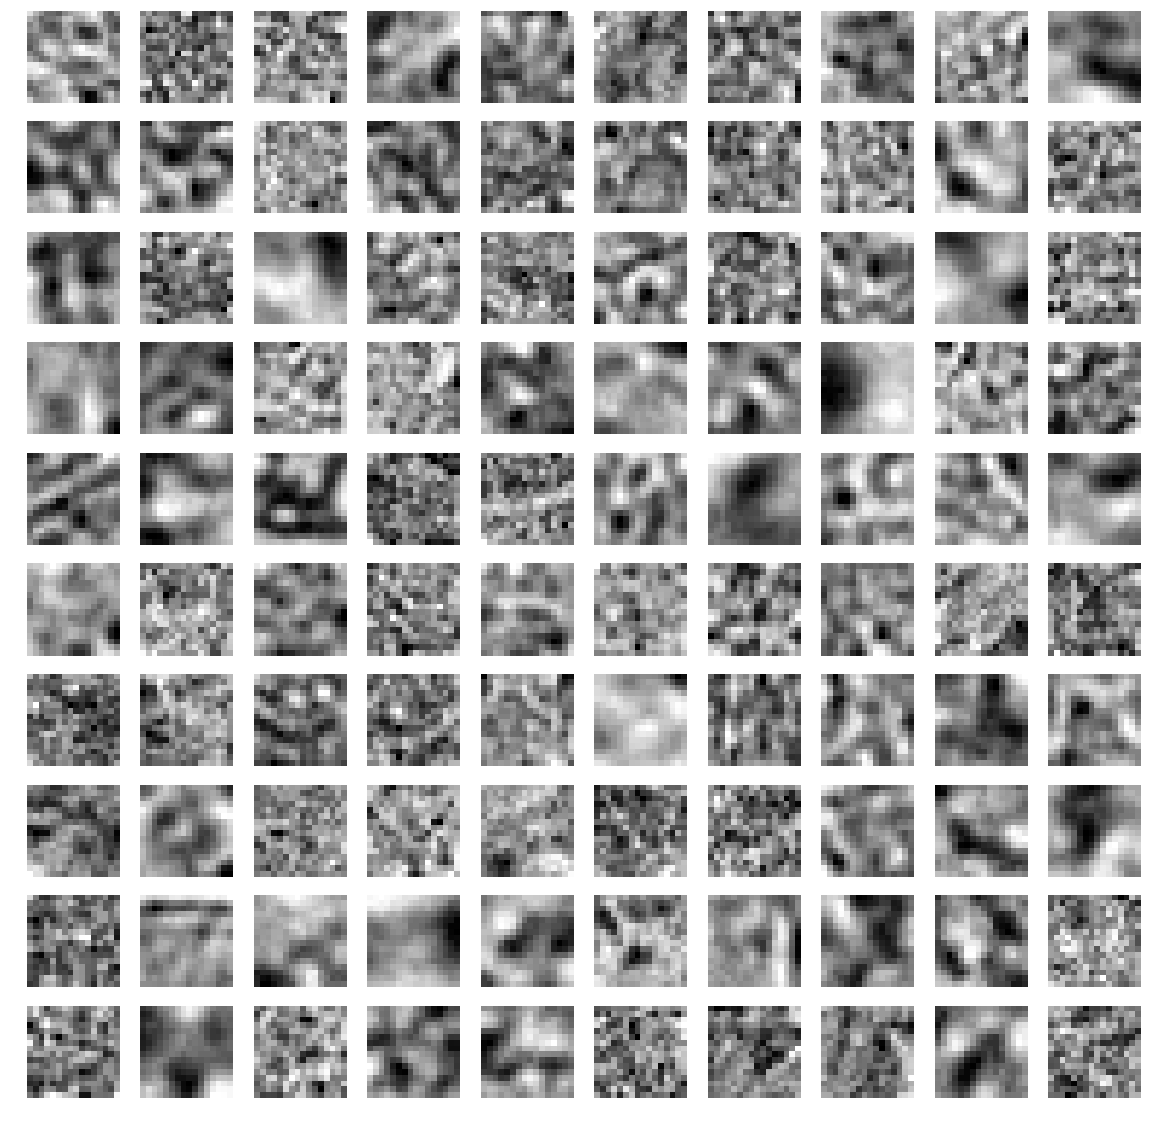

In [8]:
X, t = iterate(X, 1000, 1000) # currently at 2k iterations
display_codebook(X)

447 s
518 s


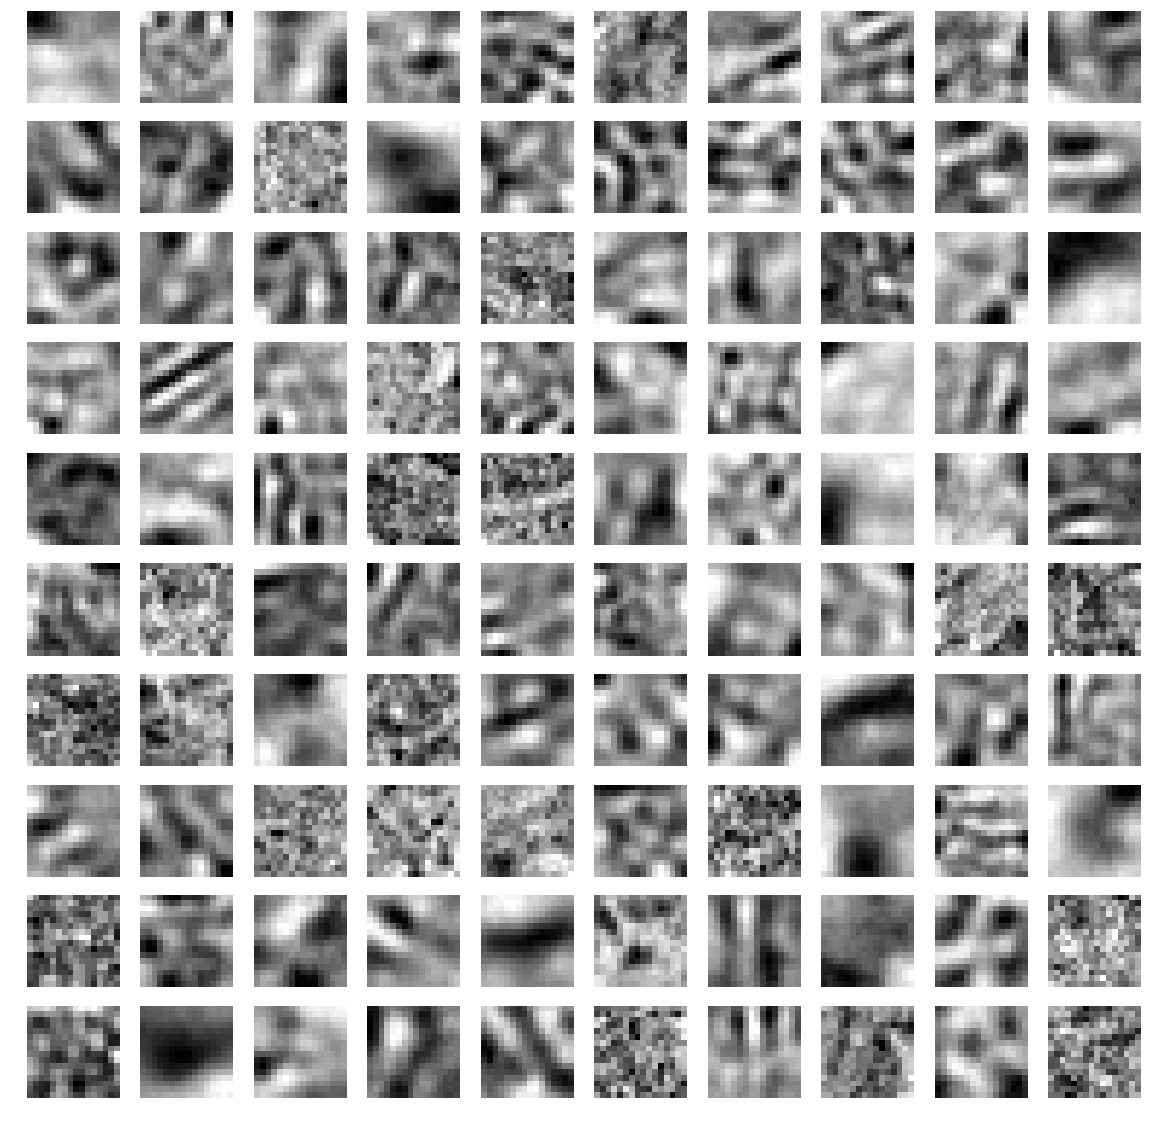

In [9]:
X, t = iterate(X,1000,2000)
X, t = iterate(X,1000,3000)
display_codebook(X)

At ~4000 iterations, we seem to mostly have well-defined edge features. While experimenting with an $\eta$ of $\frac{1}{t}$, I found that while it *did* converge sooner (at 80-100 iterations), the features were considerably more noisy than the ones we see here.

These don't look exactly like the Gabor wavelets, but a number of them *do* have singular features in the image that are consistent with Gabor wavelets.

### RECONSTRUCTION

Over our sample of $i$ values, we're going to get $i$ $\beta$s.

As I understand it, our image is going to be reconstructed as follows:

* For every $y^{(i)}$, we generate a corresponding $\beta^{(i)}$
* $X \beta^{(i)}$ is our approximation of our actual image

    ORIGINAL        RECONSTRUCTION


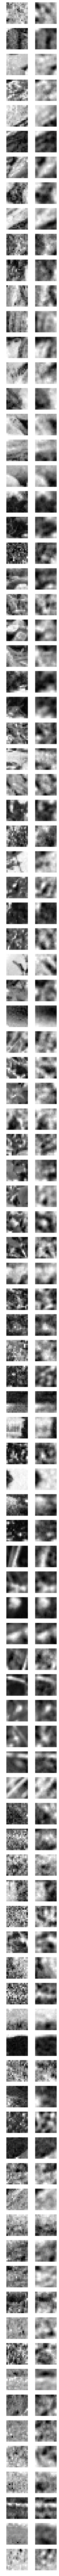

In [10]:
samples = sample_flattened_patches(images,N,img_width)
beta_matrix = pool.map(OMP, [(elem, X) for elem in samples])

ncols = 2
nrows = 100

plt.figure(figsize = (ncols*2,nrows*2))
results = []
print("    ORIGINAL        RECONSTRUCTION")
for i in range(nrows):
    img = samples[i]
    approx = numpy.dot(X, beta_matrix[i])
    results.append(img)
    results.append(approx)
for i in xrange(nrows*ncols):
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(results[i].reshape((16,16)),cmap='gray')
    plt.axis('off')
plt.axis('off')
plt.show()

In [11]:
pool.close()
pool.join()
print(":)")

:)


These are the reconstructions we're looking for (consistent with some of the examples we were shown in lecture).

Some of the more heavily pixellated 'original' examples (see towards the end) actually appear *more* defined in our approximation than in the original image. I was wondering whether or not someone had done research into using sparse coding to magnify images, and sure enough: http://www.ifp.illinois.edu/~jyang29/papers/TIP10-SR.pdf

A number of other results pertained to convolutional sparse coding, as a way to increase the effectiveness of this method. Nevertheless, this is really cool.

Recall the issue I mentioned w.r.t. the lasso method's highly variable counts of nonzero values in $\beta$ vectors. This meant that a number of the reconstructions (back when I was using the lasso method) came out completely black (e.g. all zeroes).

### Part 2: MNIST

In [12]:
from pprint import pprint
spark = SparkSession.builder.master('local[28]').appName('mnist').getOrCreate()
df = spark.read.json('/project/cmsc25025/mnist/data.json')
train, dev, test = df.rdd.randomSplit([4,1,1])
train_features = train.map(lambda x: x['features'])
vec = numpy.matrix(train_features.collect())
print(vec.shape)

(46536, 784)


Per writeup, this time we're going to be sampling the entire (28x28) image. To that end, we're going to be constructing a $784 \times d$ matrix, where for the sake of overcompleteness we're going to let $d=1000$.

A lot of our functions from before are going to work, but we're going to need a new function for properly sampling the data.

1890.95843196 s


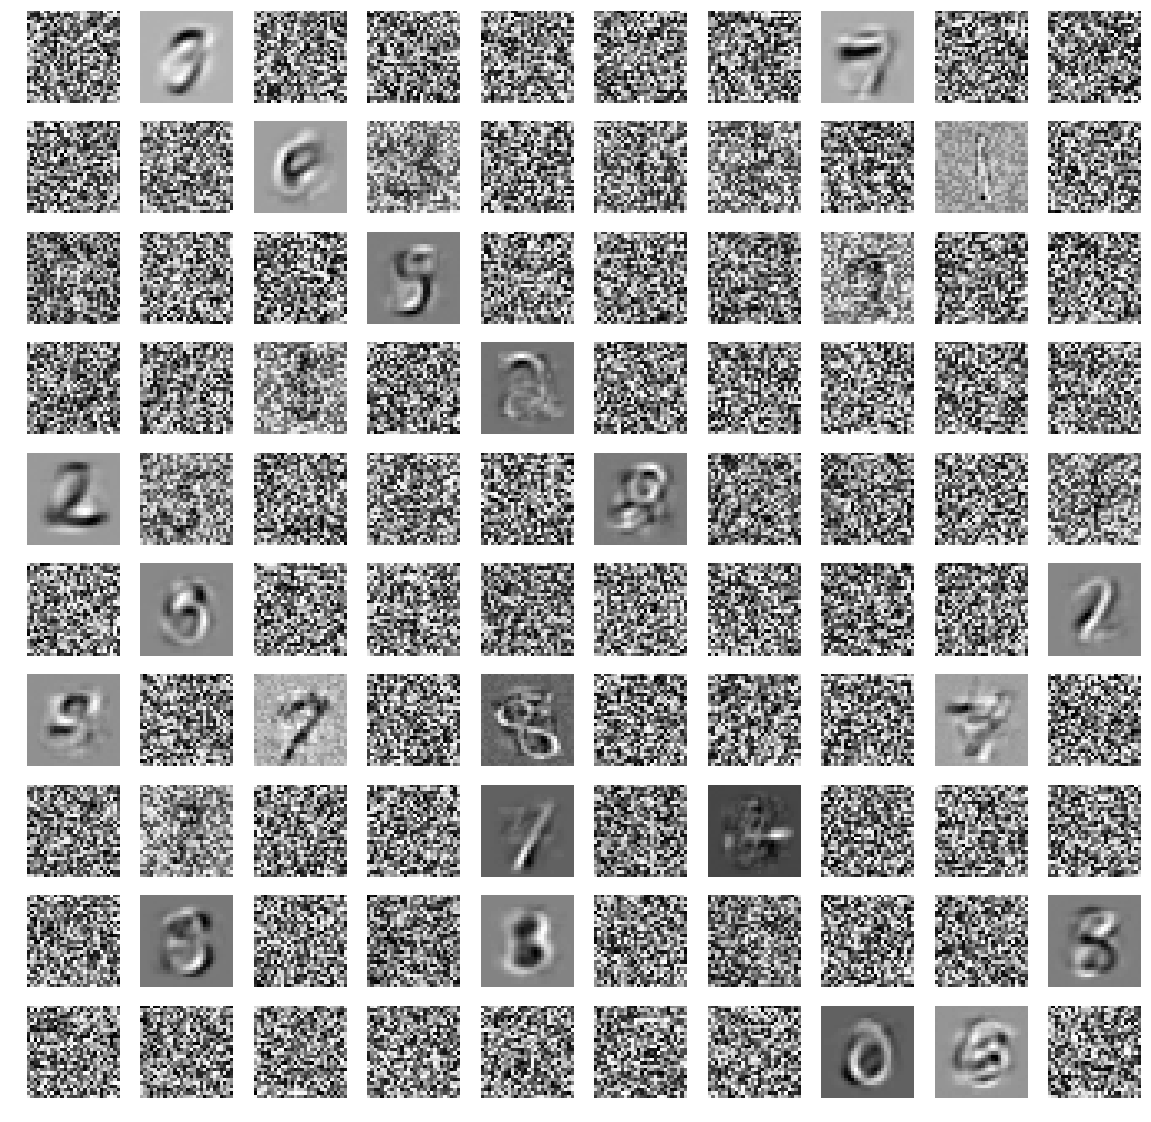

In [13]:
import time
import multiprocessing as mp
import random
d=1000 # number of atoms in code book
n=784 # length of the image vector (512x512)
N = 100 # number of images to sample per iteration
X = numpy.random.rand(n,d)

def learning_rate(t):
    """Implemented as a function for the convenience"""
    return 1/math.sqrt(t)

"""A number of these functions are from above, because
while testing the MNIST data, I kept running into namespace
issues."""

def random_indices(i,n):
    return random.sample(xrange(i),n)

def l1norm(x):
    return numpy.linalg.norm(x,ord=1)

def l2norm(x):
    return numpy.linalg.norm(x, ord=2)

def calculate_gradient(tup):
    j, y_matrix, X, beta_matrix, t = tup
    g_j = 0
    for i in range(len(y_matrix)):
        g_j += beta_matrix[i][j] * (y_matrix[i]-numpy.dot(X, beta_matrix[i]))
    g_j = learning_rate(t) * -g_j
    return g_j

def calculate_gradient_vector(y_matrix, X, beta_matrix, t, pool):
    g_j_list = [(j, y_matrix, X, beta_matrix, t) for j in range(d)]
    g_j_list = pool.map(calculate_gradient,g_j_list)
    return g_j_list

# keeping in line with the first example of 1 parameter/20 codewords
def OMP(tup, k=20):
    y, X = tup
    clf = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=10)
    clf.fit(X,y)
    beta = clf.coef_
    return beta
    
def sample_images(N, images_vec):
    images = []
    indices = random_indices(images_vec.shape[0],N)
    for i in indices:
        images.append(images_vec[i].A1)
    return images

def mnist_iterate(X, i, t_prev=1):
    start = time.time()
    for t in range(t_prev, i+1):
        y_matrix = sample_images(N,vec)
        beta_matrix = pool.map(OMP, [(elem, X) for elem in y_matrix])
        grad_list = calculate_gradient_vector(y_matrix, X, beta_matrix, t, pool)
        X = X.T
        for i in range(d):
            X[i]-= grad_list[i]
            if l2norm(X[i]>1):
                X[i] /= l2norm(X[i])
        X = X.T
    end = time.time()
    print("{} s".format(end-start))
    return(X,t_prev+i)

def display_codebook(X):
    ncols = 10
    nrows = 10
    plt.figure(figsize=(ncols*2,nrows*2))
    for i in xrange(nrows*ncols):
        plt.subplot(nrows,ncols,i+1)
        plt.imshow(X[:,i].reshape((28,28)),cmap='gray')
        plt.axis('off')
    plt.axis('off')
    plt.show()

pool = mp.Pool(mp.cpu_count())
X, t = mnist_iterate(X, 200)
display_codebook(X)

I can't actually do that many iterations of mnist training, if only because of the fact that 200 iterations with my current settings takes ~30 mins.

These reconstructions with the learning rate of $\frac{1}{\sqrt{t}}$ are definitely much more well-defined than the corresponding images from the MNIST codebook I trained with a learning rate of $\frac{1}{t}$. A number of the images from the other set suffered from much more severe cases of 'static overlay' (e.g. the 1 in the second-to-last column of the second row, or the 3 in the 3rd-to-last column of the 3rd row).

The images do contain some noise around the circle of roughly where all the digits are, with that noise being more pronounced in the cases of digits that looked similar (e.g. the cases of 5 being similar to 9, or 8 being similar to 0).

### MNIST Reconstruction


    ORIGINAL        RECONSTRUCTION


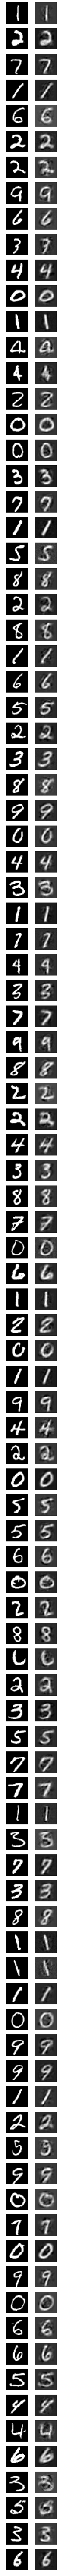

In [14]:
samples = sample_images(N,vec)
beta_matrix = pool.map(OMP, [(elem, X) for elem in samples])

ncols = 2
nrows = 100

plt.figure(figsize = (ncols*2,nrows*2))
results = []
print("    ORIGINAL        RECONSTRUCTION")
for i in range(nrows):
    img = samples[i]
    approx = numpy.dot(X, beta_matrix[i])
    results.append(img)
    results.append(approx)
for i in xrange(nrows*ncols):
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(results[i].reshape((28,28)),cmap='gray')
    plt.axis('off')
plt.axis('off')
plt.show()

In [15]:
pool.close()
pool.join()
spark.stop()
print(":D")

:D


The reconstructions correspondingly look better than the lower-learning-rate versions, which looked similar, albeit much more 'noisy.' The more 'average'-looking a digit appears to be, the less noise there is in the actual digit and the surrounding background. In the case of unusual digits (e.g. digits that are *really* slanted), the background appears to contain more noise that's been averaged out to make the background a lighter black, instead of grey.

They do, indeed, look similar to the PCA reconstructions we were presented with in class (accounting for the fact that colors are inverted).